# Notes on implementation

The core part is regularized DPP sampling algorithm. We use ```DDPY``` package to sample from $\text{DPP}_{\text{cor}}$, ```FiniteDPP``` sampler in particalar


```python
    diag_p = np.diag(p)
    Z = A + X.T @ diag_p @ X

    s, V = sp.linalg.eigh(Z)
    Z_inv_sq_root = V @ np.diag(s ** (-0.5)) @ sp.linalg.inv(V)
    B = (diag_p ** 0.5) @ X @ Z_inv_sq_root
    U, s, V = sp.linalg.svd(B, full_matrices=False)

    DPP = FiniteDPP("correlation", **{"K_eig_dec": (s, U)})
    T = DPP.sample_exact()
    b = np.random.binomial(1, p)
    S = np.union1d(T, np.where(b == 1))
```

We solve SDP problem using ```cvxpy``` package minimazing D-optimality criterion 



```python
import cvxpy as cp
import numpy as np


def cp_D_opt_criterion(cov, A: np.ndarray):
    res = cp.exp(-1.0 / cov.shape[0] * cp.log_det(cov + A))
    return res


def get_optimal_weights(X: np.ndarray, A: np.ndarray, size: int, solver="scs") -> np.ndarray:
    n, d = X.shape

    def objective(weights):
        cov = cp.multiply(weights[:, None] @ np.ones((1, d)), X).T @ X
        val = cp_D_opt_criterion(cov, A)
        return val

    weights = cp.Variable(X.shape[0])
    cp_ob = cp.Minimize(objective(weights))
    constraints = [cp.sum(weights) == size, weights <= 1, weights >= 0]
    prob = cp.Problem(cp_ob, constraints)
    if solver == "scs":
        solver = cp.SCS
    elif solver == "mosek":
        solver = cp.MOSEK

    prob.solve(solver=solver)
    # SCS solver's optimum doesn't satisfy the constrains for some reason
    return np.minimum(
        np.maximum(weights.value, np.zeros(weights.value.shape)), np.ones(weights.value.shape)
    )
```

# Experiment

$\mathbf{X} \in \mathbb{R}^{n \times d},~\mathbf{A}\in \mathbb{R}^{d \times d}$

$S \sim \text{DPP}_{\text{reg}}(\mathbf{X}, \mathbf{A})$

When not solving convex relaxation of the Bayesian experimantal design to find "optimal" probabilities $p \in [0, 1]^{n}$, they are manually set to $p=(\frac{k}{n}, \dots, \frac{k}{n})^{\top}$

In [1]:
# some imports

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.linalg
from pathlib import Path
from collections import defaultdict
import yaml
from matplotlib import pyplot as plt

In [2]:
from regdpp.general import ROOT_DIR, DATA_DIR
from regdpp.sample import SamplerRegistry
from regdpp.utils import load_libsvm_data
from regdpp.metrics import A_opt_criterion
from regdpp.plot import plot_results

In [3]:
# get config of the experiment (based on the dataset)

dataset = "mg_scale"

config_path = Path(ROOT_DIR, 'configs', f'{dataset}.yaml')
config = yaml.safe_load(config_path.open('r'))

In [4]:
print(yaml.safe_dump(config))

dataset: mg_scale
dump_path: dump
figpath: figs
methods:
  greedy:
    name: Greedy
    params: {}
    target: Greedy
  plain_reg_dpp:
    name: Reg DPP w/o SDP
    params:
      sdp: false
    target: RegDPP
  predictive_length:
    name: Predictive length
    params: {}
    target: PredictiveLength
  reg_dpp_sdp:
    name: Reg DPP w SDP
    params:
      sdp: true
    target: RegDPP
  uniform:
    name: Uniform
    params: {}
    target: Uniform
shared:
  criterion: A
  max_size_scale: 5
  min_size_scale: 1.5
  n_repeat: 25
  n_sizes: 10
ylim:
- 0
- 20



In [5]:
# run experiment

# load data
X = load_libsvm_data(config["dataset"])
n, d = X.shape

shared = config["shared"]

# define range of sizes of S
k_range = np.linspace(
    shared["min_size_scale"] * d, shared["max_size_scale"] * d, shared["n_sizes"], dtype=int
)

# number of repeats for averaging
n_repeat = shared["n_repeat"]

criteria = defaultdict(lambda: np.empty((len(k_range), n_repeat)))
times = dict()

# define precision matrix
A = 1.0 / n * np.eye(d)

for method, params in config["methods"].items():
    print(params["name"])
    target = params["target"]
    # define sampler for obtaining S
    sampler = SamplerRegistry.create_sampler(target, **params["params"])

    for k_id, k in (list(enumerate(k_range))):
        print(f"Looking for subset of size {k}")

        for rep_id in range(n_repeat):
            S = sampler(X, A, k)

            # compute A-optimality value
            X_S = X[S]
            subset_cov = X_S.T @ X_S
            A_optimal_criterium = A_opt_criterion(subset_cov, A)
            criteria[params["name"]][k_id, rep_id] = A_optimal_criterium
    
    sampler.time_cnts = np.array(sampler.time_cnts).reshape((len(k_range), n_repeat))
    if sampler.__class__.__name__ == "Greedy":
        sampler.time_cnts = np.cumsum(sampler.time_cnts[:, [0]], axis=0)
    times[params["name"]] = sampler.time_cnts
    print(
        f"Time of sampling: {np.mean(sampler.time_cnts):.3f} +- {1.96 * np.std(sampler.time_cnts):.3f}"
    )


Greedy
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time of sampling: 1.463 +- 0.942
Uniform
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time of sampling: 0.000 +- 0.000
Predictive length
Looking for subset of size 9
Looking for subset of size 11
Looking for subset of size 13
Looking for subset of size 16
Looking for subset of size 18
Looking for subset of size 20
Looking for subset of size 23
Looking for subset of size 25
Looking for subset of size 27
Looking for subset of size 30
Time

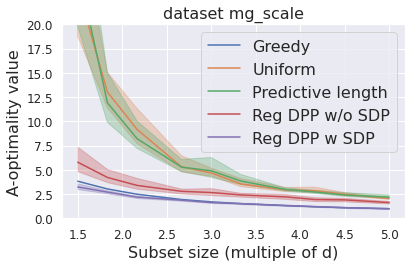

In [6]:
plot_results(
    criteria,
    k_range,
    d,
    ylabel="A-optimality value",
    ylim=config["ylim"] if config["ylim"] else None,
    dataset=config["dataset"],
    show=True
    )

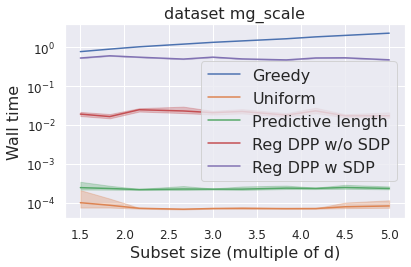

In [7]:
plot_results(
    times,
    k_range,
    d,
    ylabel="Wall time",
    dataset=config["dataset"],
    yscale="log",
    show=True
)

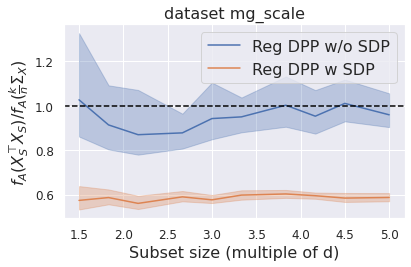

In [8]:
cov = X.T @ X
baseline = np.array([A_opt_criterion(k / n * cov, A) for k in k_range])
criteria_ = {
    config["methods"][key]["name"]: criteria[config["methods"][key]["name"]] / baseline[:, None]
    for key in ["plain_reg_dpp", "reg_dpp_sdp"]
}
fig = plot_results(criteria_, k_range, d, dataset=config["dataset"])
plt.ylabel(r"$f_A(X_S^{\top}X_S)/f_A(\frac{k}{n}\Sigma_X)$")
plt.axhline(y=1.0, color="black", linestyle="--")
fig.tight_layout()
plt.show()